## Carregando os pacotes

In [26]:
library(dplyr) # manipulação dos dados
library(ggplot2) # visualização
library(gridExtra) # visualizar vários gráficos juntos
library(tidytext) # mineração de texto
library(wordcloud2) # criação de núvem de palavras

## Lendo os dados

In [2]:
prince_orig <- read.csv("data/prince_raw_data.csv", stringsAsFactors = FALSE)

In [3]:
# Colunas da base de dados
names(prince_orig)

[1] "X"            "text"         "artist"       "song"         "year"        
 [6] "album"        "Release.Date" "US.Pop"       "US.R.B"       "CA"          
[11] "UK"           "IR"           "NL"           "DE"           "AT"          
[16] "FR"           "JP"           "AU"           "NZ"           "peak"

In [4]:
# Selecionando algumas colunas 
prince <- prince_orig  %>% 
    select(lyrics = text, song, year, album, peak, us_pop = US.Pop, us_rnb = US.R.B)

glimpse(prince[139,])

Observations: 1
Variables: 7
$ lyrics <chr> "I just can't believe all the things people say, controversy\n…
$ song   <chr> "controversy"
$ year   <int> 1981
$ album  <chr> "Controversy"
$ peak   <int> 3
$ us_pop <chr> "70"
$ us_rnb <chr> "3"


In [5]:
dim(prince)

[1] 824   7

In [6]:
str(prince[139,]$lyrics, nchar.max = 300)

 chr "I just can't believe all the things people say, controversy\nAm I Black or White? Am I straight or gay? Controversy\nDo I believe in God? Do I believe in me? Controversy\nControversy, controversy\nI can't understand human curiosity, controversy\nWas it good for you? Was I what you w"| __truncated__


## Limpeza básica

In [7]:
# Função responsável por remover as contrações da língua inglesa
fix.contractions <- function(doc) {
    doc <- gsub("won't", "will not", doc)
    doc <- gsub("can't", "can not", doc)
    doc <- gsub("n't", " not", doc)
    doc <- gsub("'ll", "will", doc)
    doc <- gsub("'re", " are", doc)
    doc <- gsub("'ve", " have", doc)
    doc <- gsub("'m", " am", doc)
    doc <- gsub("'d", " would", doc)
    doc <- gsub("'s", "", doc)
    return(doc)
}

In [8]:
prince$lyrics <- sapply(prince$lyrics, fix.contractions)

In [9]:
# Função responsável por remover caracteres especiais
removeSpecialChars <- function(x) gsub("[^a-zA-Z0-9 ]", " ", x)

# Removendo os caracteres especiais
prince$lyrics <- sapply(prince$lyrics, removeSpecialChars)

In [10]:
# Convertendo todas as letras para minúsculo
prince$lyrics <- sapply(prince$lyrics, tolower)

In [11]:
str(prince[139,]$lyrics, nchar.max = 300)

 chr "i just can not believe all the things people say  controversy am i black or white  am i straight or gay  controversy do i believe in god  do i believe in me  controversy controversy  controversy i can not understand human curiosity  controversy was it good for you  was i what you wa"| __truncated__


In [12]:
summary(prince)

    lyrics              song                year         album          
 Length:824         Length:824         Min.   :1978   Length:824        
 Class :character   Class :character   1st Qu.:1989   Class :character  
 Mode  :character   Mode  :character   Median :1996   Mode  :character  
                                       Mean   :1995                     
                                       3rd Qu.:1999                     
                                       Max.   :2015                     
                                       NA's   :495                      
      peak          us_pop             us_rnb         
 Min.   : 0.00   Length:824         Length:824        
 1st Qu.: 2.00   Class :character   Class :character  
 Median : 7.00   Mode  :character   Mode  :character  
 Mean   :15.48                                        
 3rd Qu.:19.00                                        
 Max.   :88.00                                        
 NA's   :751                   

In [13]:
# Anos dos dados
unique(prince$year)  %>% sort()

[1] 1978 1979 1980 1981 1982 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
[16] 1994 1995 1996 1998 1999 2001 2002 2004 2006 2007 2009 2010 2015

## Adicionando novas colunas

In [14]:
prince <- prince  %>% 
    mutate(decade =
                ifelse(prince$year %in% 1978:1979, "1970s",
                ifelse(prince$year %in% 1980:1989, "1980s",
                ifelse(prince$year %in% 1990:1999, "1990s",
                ifelse(prince$year %in% 2000:2009, "2000s",
                ifelse(prince$year %in% 2010:2019, "2010s",
                       "NA")))))
          )

In [15]:
prince <- prince  %>% 
    mutate(chart_level = 
           ifelse(prince$peak %in% 1:10, 'Top 10',
                 ifelse(prince$peak %in% 11:100, 'Top 100', 'Uncharted'))
    )

In [16]:
prince <- prince  %>% 
    mutate(charted = ifelse(prince$peak %in% 1:100, 'Charted', 'Uncharted'))

# Salvando o novo DataFrame
write.csv(prince, file = 'data/prince_new.csv')

# Estatística descritiva

In [17]:
my_colors <- c('#E69F00', '#56B4E9', '#009E73', '#CC79A7', '#D55E00')

theme_lyrics <- function() {
    theme(plot.title = element_text(hjust = 0.5),
         axis.text.x = element_blank(),
         axis.ticks = element_blank(),
         panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(),
         legend.position = 'none')
}

## Estatística da música

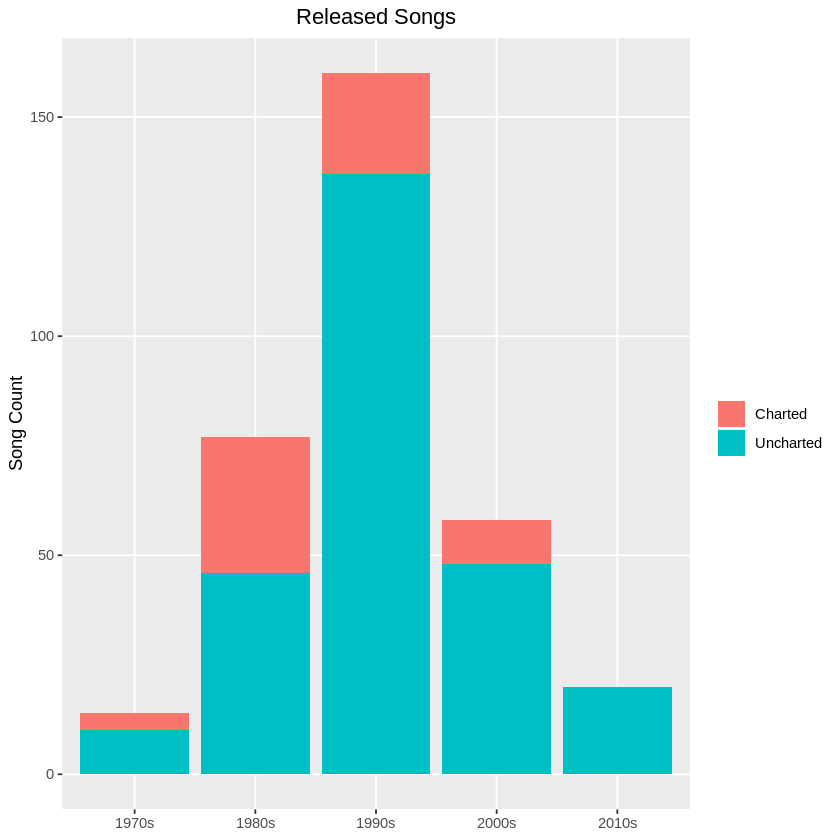

In [18]:
prince  %>% 
    filter(decade != 'NA')  %>% 
    group_by(decade, charted)  %>% 
    summarise(number_of_songs = n())  %>% 
    ggplot() +
    geom_bar(aes(x = decade, y = number_of_songs,
                fill = charted), stat = 'identity') +
    theme(plot.title = element_text(hjust = 0.5),
         legend.title = element_blank(),
         panel.grid.minor = element_blank()) +
    ggtitle('Released Songs') +
    labs(x = NULL, y = 'Song Count')

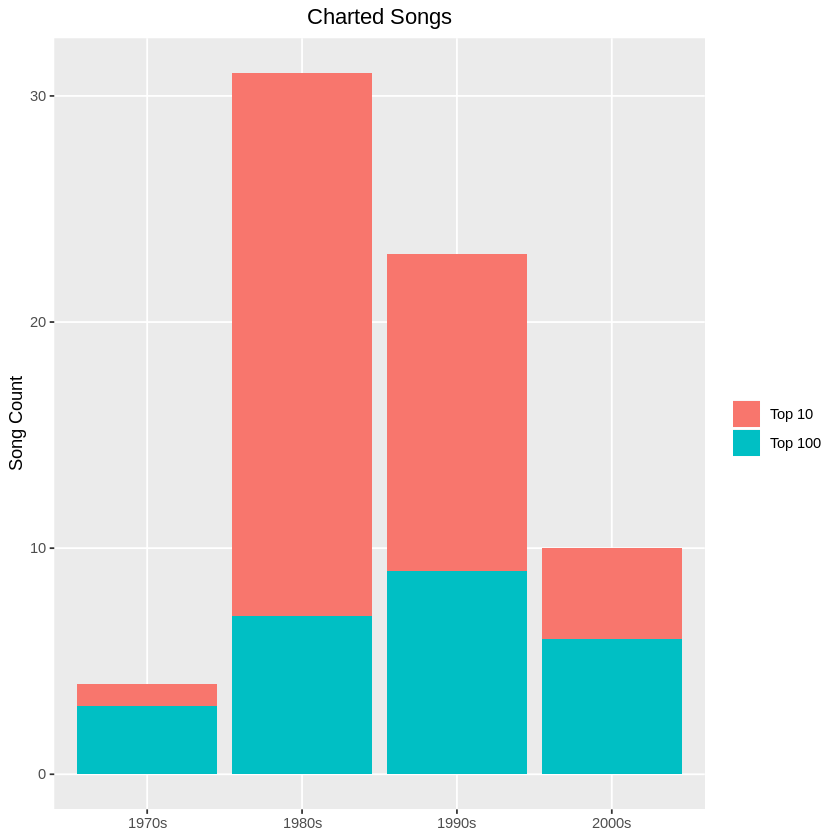

In [19]:
charted_songs_over_time <- prince  %>% 
    filter(peak > 0)  %>% 
    group_by(decade, chart_level)  %>% 
    summarise(number_of_songs = n())

charted_songs_over_time  %>% 
    ggplot() +
    geom_bar(aes(x = decade, y = number_of_songs,
                fill = chart_level), stat = 'identity') +
    theme(plot.title = element_text(hjust = 0.5),
         legend.title = element_blank(),
         panel.grid.minor = element_blank()) +
    labs(x = NULL, y = 'Song Count') +
    ggtitle('Charted Songs')

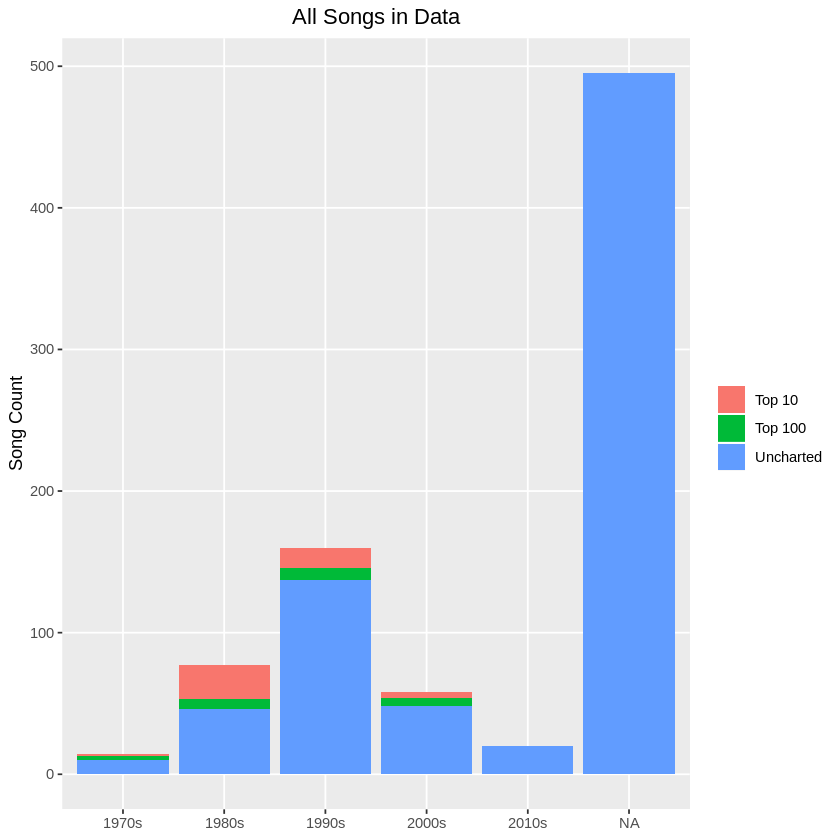

In [22]:
# Verificando todo os dados sem filtro
prince  %>% 
    group_by(decade, chart_level)  %>% 
    summarise(number_of_songs = n())  %>% 
    ggplot() +
    geom_bar(aes(x = decade, y = number_of_songs,
                fill = chart_level), stat = 'identity') +
    theme(plot.title = element_text(hjust = 0.5),
         legend.title = element_blank(),
         panel.grid.minor = element_blank()) +
    labs(x = NULL, y = 'Song Count') +
    ggtitle('All Songs in Data')

## Música número 1!

In [30]:
library(knitr)
library(kableExtra)
library(formattable)

In [37]:
# Criando tabela das músicas top 1  por ano
tabela = prince  %>% 
    filter(peak == '1')  %>% 
    select(year, song, peak)  %>% 
    arrange(year)  %>% 
    mutate(year = color_tile('lightblue', 'lightgreen')(year))  %>% 
    mutate(peak = color_tile('lightgreen', 'lightgreen')(peak))  %>% 
    kable('html', escape = FALSE, align = 'c', caption = "Prince's No. 1 Songs")  %>% 
        kable_styling(bootstrap_options = c('striped', 'condensed', 'bordered'),
                     full_width = FALSE)